# Quantum Walk Implementation Using Classiq's Python SDK

Womanium Quantum+AI 2024 - Classiq Quantum Algorithms Development II Assignment

Made by: Yamen Ghozlan

This notebook implements a Discrete-Time Quantum Walk on a graph $G(V,\ E)$, where $V$ is the set of vertices and $E$ is the set of edges. The following figure represents graph $G$:

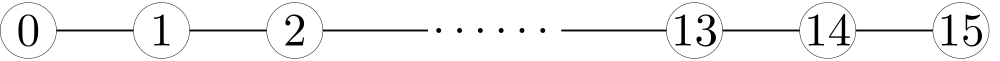

### Definition

A quantum walk is an analog of a classical random walk, where quantum mechanics allow the walker to occupy a superposition of multiple states, unlike a classical random walk, where the walker is in a single state.

A discrete quantum walk is a model where the walker moves between a fixed number of states at each discrete time step.

### Encoding
To encode the information of the graph into the algorithm, we define two registers, one to hold the information of the vertices and the other to hold the information of the neighbors of each vertex. These registers have a size of $\lceil log_2(|V|)\rceil$, where $|V|$ is the number of vertices in the graph. Such that the state $|j,k\rangle$ represents moving from vertex $j$ toward vertex $k$.

We also need to be able to represent and define a uniform superposition of a vertex's neighbors. We assume we have an operator $U$ such that when given $j$ it results in a uniform superposition of all of $j$'s neighbors. Such that:
$$ |j\rangle \xrightarrow{U} | \partial_j \rangle := \frac{1}{\sqrt{deg(j)}} \sum_{k:(j, k) \in E} | k \rangle $$



### Evolution
In Discrete-Time Quantum Walk we move from any given vertex to each of its neighbors with equal probability at each step. A single step of a the walk is defined as applying the operators $SC$ to the state $|j,k\rangle$. The operator $C$ is the Grover's diffusion operator over the neighbors of the vertex and is defined as:

$$ C := \sum_{j \in V} | j \rangle \langle j | \otimes (2 | \partial_j \rangle \langle \partial_j | - I) $$

And the operator $S$, a bitwise-swap operator that swaps all bits of $j$ with $k$, is defined as:
$$ S := \sum_{(j, k) \in E} | j, k \rangle \langle k, j | $$


### Implementation

Now we break down the operator $C$ to be able to implement it and express it in code. The first part of the operator, $| j \rangle \langle j |$, is basically a control, which means the second part is applied if the first register is equal to $j$.

For the second part we can break it down as such:
$$ 2 | \partial_j \rangle \langle \partial_j | - I = 2 (U_j| 0 \rangle \langle 0 |U_j^\dagger) - I = 2 U_j| 0 \rangle \langle 0 |U_j^\dagger - U_jU_j^\dagger = U_j(2 | 0 \rangle \langle 0 | - I) U_j^\dagger; \quad \text{where}\ U_j|0\rangle = |\partial_j\rangle  $$

We can see that the operator consists of applying $U_j$ then applying a zero diffuser, which can be expressed as the oracle  $(-1)^{j \neq 0}$, lastly we apply $U_j^\dagger$.

Next is the operator $S$ which can be implemented using a bitwise-swap over all bits of $j$ and $k$.

#### Graph Specific Implementation

We implement $U_j$, which encodes the adjacency information of the graph. We do this by preparing a uniform superposition of the state before $j$ and the state after it, unless $j$ is on the ends of the graph. We define the application of this operator as:

$$U_j |0\rangle = \begin{cases} \frac{1}{\sqrt{2}}(|j-1\rangle + |j+1\rangle) & 0 < j < 15 \\ |1\rangle & j=0 \\ |14\rangle & j=15 \end{cases}$$

Finally, we need a way to check if $k$ is a neighbor of $j$. We can simply check for the absolute difference between $j$ and $k$, if it's equal to 1 then they are adjacent, otherwise they're not.

$$edge(j, k) := abs(j - k) = 1$$

### Implementation in Classiq's Python SDK

In [1]:
from classiq import *
from classiq.execution import ExecutionPreferences
from classiq.synthesis import Constraints

In [2]:
from classiq import *

SIZE = 4
NUM_NODES = 2**SIZE

#### Implementing $C$ Operator

In [3]:
@qfunc
def prepare_minus(x: QBit):
    X(x)
    H(x)


@qfunc
def diffuser_oracle(aux: Output[QNum], x: QNum):
    aux ^= x != 0


@qfunc
def zero_diffuser(x: QNum):
    aux = QNum("aux")
    allocate(1, aux)
    within_apply(compute=lambda: prepare_minus(aux), action=lambda: diffuser_oracle)


def c_iteration(i: int, vertices: QNum, adjacent_vertices: QNum):
    prob = [0] * NUM_NODES
    p = 0.5 if 0 < i < NUM_NODES - 1 else 1
    if i != 0:
        prob[(i - 1)] = p
    if i != NUM_NODES - 1:
        prob[(i + 1)] = p

    print(f"State={i}, prob vec ={prob}")

    control(
        ctrl=vertices == i,
        operand=lambda: within_apply(
            compute=lambda: inplace_prepare_state(
                probabilities=prob, bound=0.01, target=adjacent_vertices
            ),
            action=lambda: zero_diffuser(adjacent_vertices),
        ),
    )


@qfunc
def c_operator(vertices: QNum, adjacent_vertices: QNum):
    for i in range(NUM_NODES):
        c_iteration(i, vertices, adjacent_vertices)

#### Implementing $S$ Operator

In [4]:
@qfunc
def edge_oracle(res: Output[QBit], vertices: QNum, adjacent_vertices: QNum):
    res |= ((vertices - adjacent_vertices) == 1) | ((adjacent_vertices - vertices) == 1)


@qfunc
def bitwise_swap(x: QArray[QBit], y: QArray[QBit]):
    repeat(count=x.len, iteration=lambda i: SWAP(x[i], y[i]))


@qfunc
def s_operator(vertices: QNum, adjacent_vertices: QNum):
    res = QNum("res")
    edge_oracle(res, vertices, adjacent_vertices)
    control(ctrl=res == 1, operand=lambda: bitwise_swap(vertices, adjacent_vertices))

The main function starts with a superposition of all vertices then applies $SC$

In [5]:
@qfunc
def main(vertices: Output[QNum], adjacent_vertices: Output[QNum]):

    allocate(SIZE, vertices)
    hadamard_transform(vertices)
    allocate(SIZE, adjacent_vertices)

    c_operator(vertices, adjacent_vertices)
    s_operator(vertices, adjacent_vertices)

In [7]:
qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=1, prob vec =[0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=2, prob vec =[0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=3, prob vec =[0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=4, prob vec =[0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=5, prob vec =[0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0, 0]
State=6, prob vec =[0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0, 0]
State=7, prob vec =[0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0, 0]
State=8, prob vec =[0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0, 0]
State=9, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0, 0]
State=10, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0, 0]
State=11, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0, 0]
State=12, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 0.5, 0, 0]
State=13, prob vec =[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0.5, 0, 

Opening in existing browser session.


### Conclusion

The probability vectors of $\partial_j$ indicate the exact adjacency of each vertex in the graph $G$, where each node is connected only to the one before it and the one after it.

The following images provide a high-level view of the synthesized program. Note that a more detailed view would be too large to include in this notebook.

We can see that the circuit first puts the vertex qubits in a superposition using Hadamard transform, then both the $C$ and the $S$ operators are being applied.


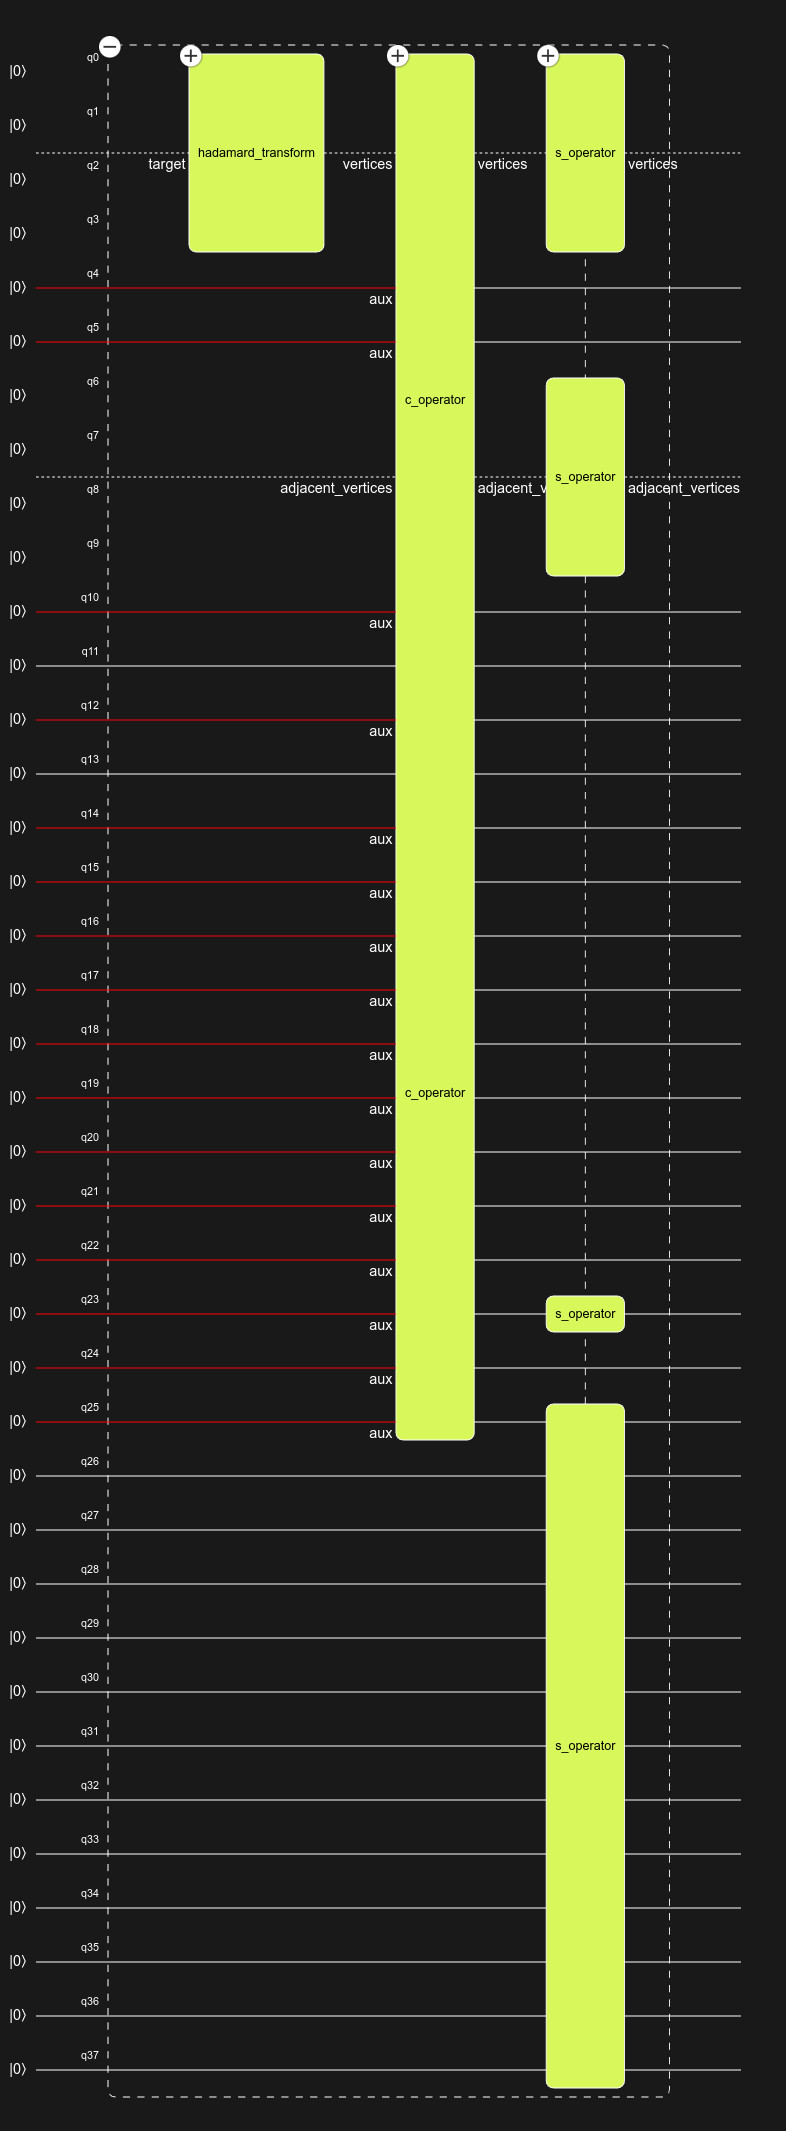

Expanding the $S$ operator reveals the implementation of the edge oracle and the swap operation.

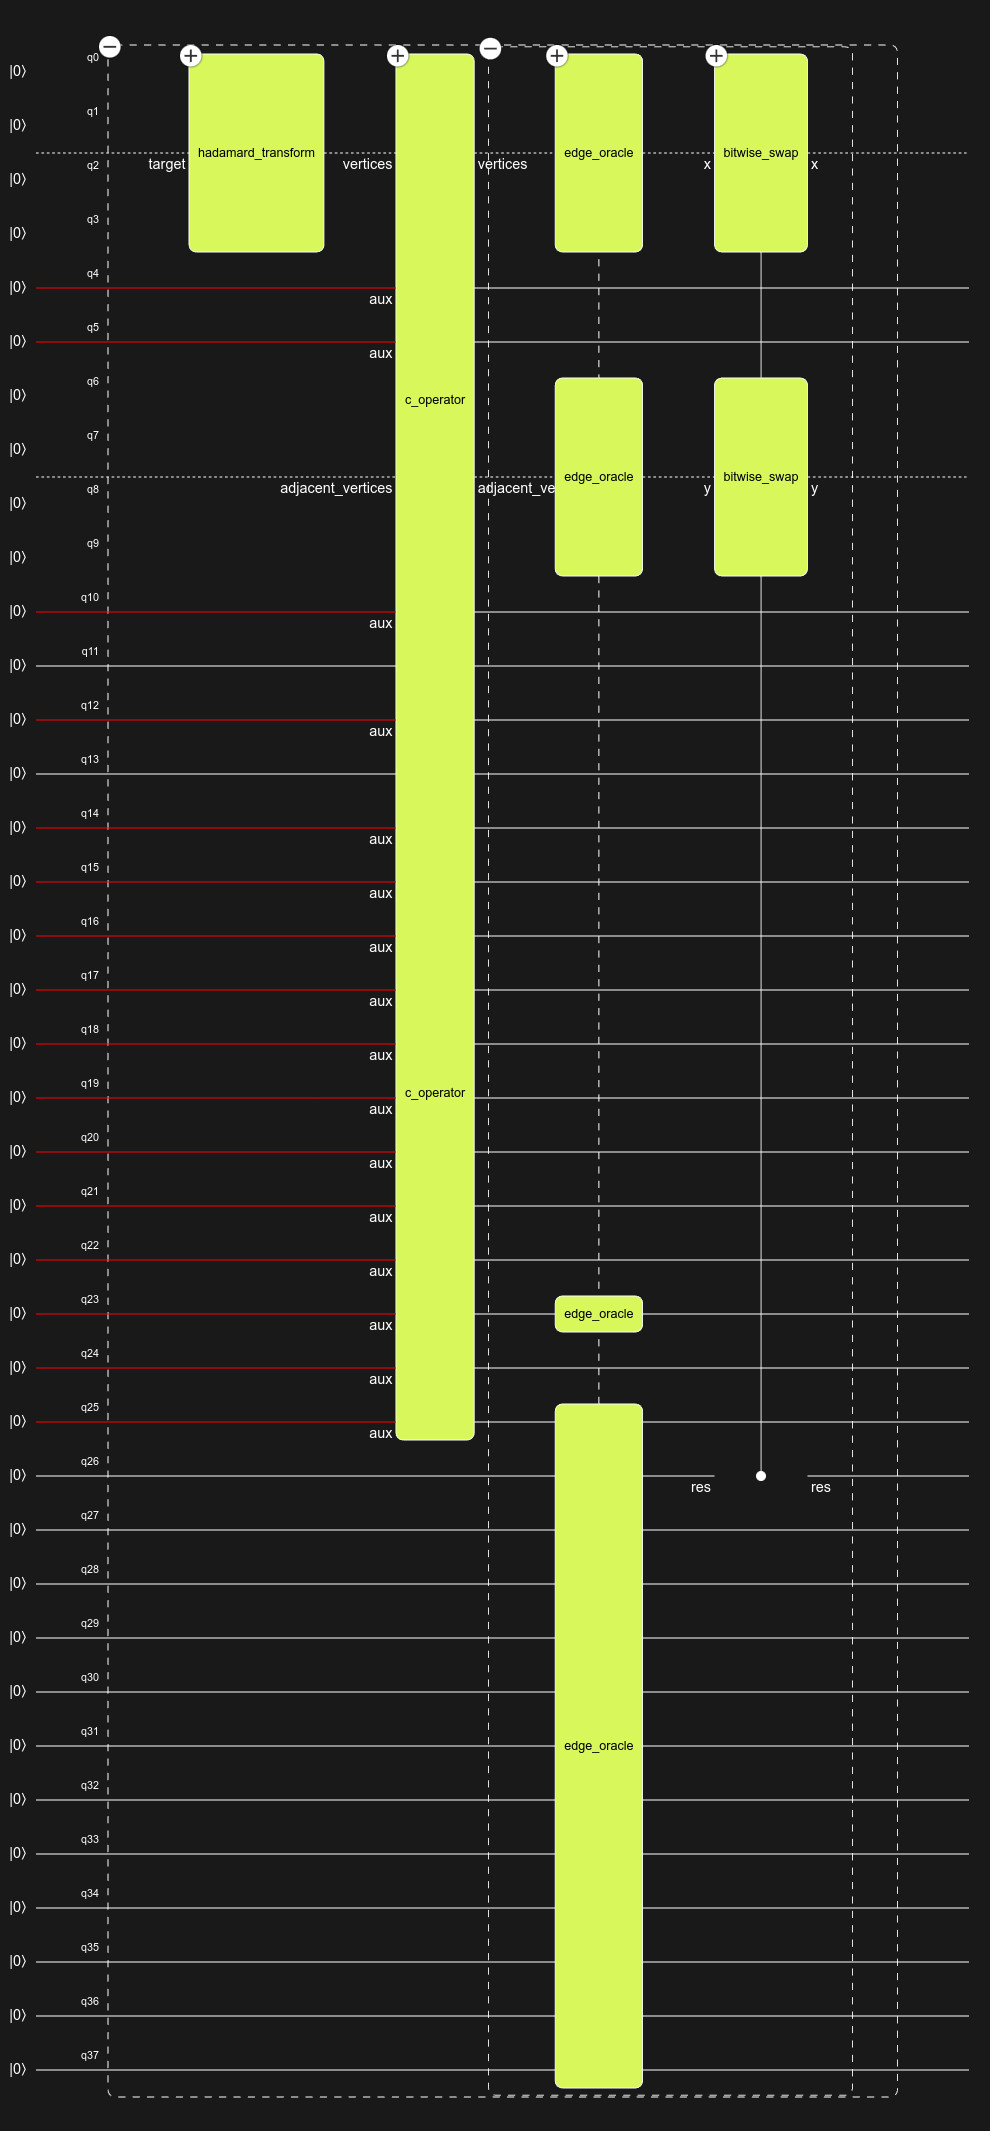